In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [4]:
# import dataset as data
df = pd.read_json('MLandStatsDataSet.json')
df = df.set_index(df['login_time'])
df['ride'] = 1
data_15 = df.groupby(pd.Grouper(freq = '15Min')).agg({'ride':'count'}).reset_index()
data_15['weekday'] = data_15['login_time'].dt.weekday
data_15['hour'] = data_15['login_time'].dt.hour
data_15['minute'] = data_15['login_time'].dt.minute
data_15['day'] = data_15['login_time'].dt.day
data_15 = data_15.drop(columns = 'login_time')
print(data_15.head())

   ride  weekday  hour  minute  day
0     3        4     0       0    1
1     3        4     0      15    1
2     7        4     0      30    1
3     7        4     0      45    1
4     5        4     1       0    1


19
0


In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # data series
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)'%(j+1, i)) for j in range(n_vars)]
    # predicted data
    for i in range(0, n_out, 1):
        cols.append(df.shift(-i))
        if i==0:
            names+=[('var%d(t)'%(j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d))'%(j+1, i)) for j in range(n_vars)]
    # concatination
    agg = concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [30]:
values = data_15.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
# Converted to supervised learning
reframed = series_to_supervised(values, 1, 1)
print(reframed.head())

          0         1         2         3    4         0         1         2  \
1  0.157895  0.666667  0.000000  0.000000  0.0  0.157895  0.666667  0.000000   
2  0.157895  0.666667  0.000000  0.333333  0.0  0.368421  0.666667  0.000000   
3  0.368421  0.666667  0.000000  0.666667  0.0  0.368421  0.666667  0.000000   
4  0.368421  0.666667  0.000000  1.000000  0.0  0.263158  0.666667  0.043478   
5  0.263158  0.666667  0.043478  0.000000  0.0  0.263158  0.666667  0.043478   

          3    4  
1  0.333333  0.0  
2  0.666667  0.0  
3  1.000000  0.0  
4  0.000000  0.0  
5  0.333333  0.0  


train_x.shape, train_y.shape, test_x.shape, test_y.shape
(20000, 1, 9) (20000,) (3003, 1, 9) (3003,)
Train on 20000 samples, validate on 3003 samples
Epoch 1/100
 - 7s - loss: 0.1072 - val_loss: 0.0954
Epoch 2/100
 - 5s - loss: 0.0995 - val_loss: 0.0943
Epoch 3/100
 - 5s - loss: 0.0984 - val_loss: 0.0939
Epoch 4/100
 - 5s - loss: 0.0975 - val_loss: 0.0927
Epoch 5/100
 - 5s - loss: 0.0970 - val_loss: 0.0924
Epoch 6/100
 - 7s - loss: 0.0966 - val_loss: 0.0918
Epoch 7/100
 - 6s - loss: 0.0963 - val_loss: 0.0917
Epoch 8/100
 - 6s - loss: 0.0960 - val_loss: 0.0910
Epoch 9/100
 - 6s - loss: 0.0956 - val_loss: 0.0903
Epoch 10/100
 - 7s - loss: 0.0954 - val_loss: 0.0899
Epoch 11/100
 - 6s - loss: 0.0952 - val_loss: 0.0896
Epoch 12/100
 - 5s - loss: 0.0950 - val_loss: 0.0891
Epoch 13/100
 - 5s - loss: 0.0948 - val_loss: 0.0887
Epoch 14/100
 - 5s - loss: 0.0946 - val_loss: 0.0888
Epoch 15/100
 - 5s - loss: 0.0943 - val_loss: 0.0885
Epoch 16/100
 - 5s - loss: 0.0941 - val_loss: 0.0881
Epoch 17/10

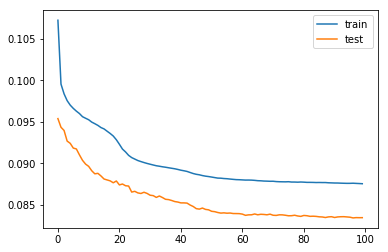

Test RMSE:0.107


In [8]:
values = reframed.values
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
values = scaled
# selected first seven monthes as training data
n_train_hours = 20000

# split training and test set
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_x, train_y = train[:, 1:], train[:, 0]
test_x, test_y = test[:, 1:], test[:, 0]

#reshape input to the LSTM format
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print('train_x.shape, train_y.shape, test_x.shape, test_y.shape')
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
 
# Model defination
#-------------------------
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
 
# train model
#------------------------
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(test_x, test_y), verbose=2, shuffle=False)
 
# plot output
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# prediction
# the max ride is 19 and min is 0
#------------------------
yhat = model.predict(test_x)
inv_yhat = yhat * 19
test_x = test_x.reshape(test_x.shape[0], test_x.shape[2])
# predicted data inversion
# inv_yhat = concatenate((yhat, test_x[:, 1:]), axis=1)       
# # inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, 0]
# label inversion
test_y = test_y.reshape(len(test_y), 1)
inv_y = test_y * 19
# # inv_y = concatenate((test_y, test_x[:, 1:]), axis=1)
# # inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, 0]
# compute MSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE:%.3f'%rmse)

In [18]:
inv_yhat = yhat * 19
inv_y = test_y * 19
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE:%.3f'%rmse)

Test RMSE:2.036


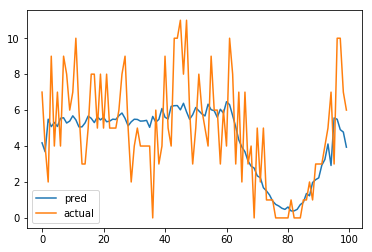

In [28]:
x = range(0, 100)
pyplot.plot(x, inv_yhat[0:100], label = 'pred')
pyplot.plot(x, inv_y[0:100], label = 'actual')
pyplot.legend()